# Data Programming - Assignment 2
## Combining geographical numerical and textual data

### Handed out: 28/11/2018 - Due: 13/1/2019

In this assignment you will combine weather and geonames data to find Europe's windiest cities.

Open a terminal and issue the following commands:

`$ conda install basemap
$ pip install wget
`

Accept all to install the extra packages required.

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import wget
import csv
import os.path

___Note:___ In case Python complains while executing the above, raising a `KeyError: 'PROJ_LIB'`, do the following:

1. Set an environment variable CONDA_PREFIX by appending the following to your `~/.bashrc` file:
```
export CONDA_PREFIX=/opt/anaconda3  # or whichever your Anaconda root directory is
export PROJ_LIB=$CONDA_PREFIX/share/proj 
```
2. Restart your terminal and your jupyter-notebook session.


For this assignment you will need to download the following 3 files. The first one is ~343MB.

http://iit.demokritos.gr/~iaklampanos/assign3_data.npz
http://iit.demokritos.gr/~iaklampanos/lat.npy
http://iit.demokritos.gr/~iaklampanos/lon.npy
http://download.geonames.org/export/dump/cities5000.zip`


**(1) Write a generic function to download a file from the Web (given a URL), if it is not already present locally. The function should be parameterisable w.r.t. the local directory to be used, the default being the current working directory (`./`). Use this function to assign values to variables `data_filename`, `lat_filename` and `lon_filename`. [2 marks]**

*Hint: Use the wget package.*

*Hint: When developing use the smaller `lat.npy` or `lon.npy` files.*

*Optional: Implement a function to allow wget to display the download progress in %. Try to find your way using `help(wget)` and by looking up the source code of wget online.*

In [2]:
def fetch_data(web_file, local_dir='.'):
    """Download the `web_file`, assuming it is a web resource into the local_dir. 
    If a file with the same filename already exists in the local directory, do not 
    download it but return its path instead.
    Arguments:
        web_file: a web resource identifiable by a url (str)
        local_dir: a local directory to download the web_file into (str)
    Return: The local path to the file (str)
    """
    fname = web_file.split("/")[-1]
    if os.path.isfile(fname):
        print (fname +" already exists in local directory")
        
    else:
        print(fname + " not found. Trying to download...")
        wget.download(web_file)
        
    return os.path.abspath(fname)
    
    pass
data_filename = fetch_data('http://iit.demokritos.gr/~iaklampanos/assign2_data_SMALL.npz') or 'assign2_data_SMALL.npz'
lat_filename = fetch_data('http://iit.demokritos.gr/~iaklampanos/lat.npy') or 'lat.npy'
lon_filename = fetch_data('http://iit.demokritos.gr/~iaklampanos/lon.npy') or 'lon.npy'
cities_filename = fetch_data('http://download.geonames.org/export/dump/cities5000.zip') or 'cities5000.zip'

assign2_data_SMALL.npz already exists in local directory
lat.npy already exists in local directory
lon.npy already exists in local directory
cities5000.zip already exists in local directory


The first three pieces of data you have downloaded are all numpy arrays which you can deserialise using `np.load`, as shown below.

In [3]:
data = np.load(data_filename, encoding='bytes')['c137']
lat = np.load(lat_filename)
lon = np.load(lon_filename)

The geonames data (`cities5000.zip`) contains a text file (`cities5000.txt`) of tab-separated values. The description of this data is at http://download.geonames.org/export/dump/readme.txt. It lists the geographical locations and names of the cities with a population > 5000. 

**Unzip `cities5000.zip` to obtain `cities5000.txt`.**

** (2) In this exercise we will need to extract the fields geonamesid, name, asciiname, 
latitude, longitude, contry code, population, elevation, dem and time zone (10 in total). Write a basic class providing a human-readable enumeration to the fields above, corresponding to the format of the `cities5000.txt` file. [2 marks] **

*Hint: e.g. for the field time zone, which is the 17th field in the file, we want to write F.TZ instead of 17. This will make our code more readable and more maintainable (e.g. in case the format changes in the future).*

In [58]:
class F(object):

    def __init__(self):
        """ Create a new point at the origin """
        self.geonamesid = 1
        self.name = 2
        self.asciiname = 3
        self.latitude = 4
        self.longitude = 5
        self.countrycode = 6
        self.population = 7
        self.elevation = 8
        self.dem = 9
        self.timezone = 10 

    pass

** (3) Write a function to read cities5000.txt into a Python list, retaining the fields geonamesid, name, asciiname, latitude, longitude, contry code, population, elevation, dem and time zone. Use the class you defined above. [2 marks] **

In [5]:
def load_cities(filename='cities5000.txt'):
    """Parse cities5000.txt and return a list containing a subset of its fields."""
    indeces = [0,1,2,4,5,8,14,15,16,17]
    cities_list = []
    for row in csv.reader(open('cities5000.txt', 'r'), delimiter='\t'):
        list = [row[0],row[1], row[2], row[4], row[5], row[8], row[14], row[15], row[16], row[17]]
        f = F()
        f.geonamesid = row[0]
        f.name = row[1]
        f.asciiname = row[2]
        f.latitude = float(row[4])
        f.longitude = float(row[5])
        f.countrycode = row[8]
        f.population = int(row[14])
        f.elevation = row[15]
        f.dem = row[16]
        f.timezone = row[17]
        cities_list.append(f) 
    return cities_list
    pass
cities = load_cities()

**(4) Write a function that given a list of cities in the format above it selects cities based on their latitude and longitude, and minimum population. We want all cities within two pairs of (lat,long), with a population >= `population`. Use your function to get all european cities (coordinates provided below) with a population >= 100000 [2 marks] **

In [6]:
def latlong_filter(lat1, lon1, lat2, lon2, population=5000, cities=cities):
    """Return a sublist of the geonames cities from a northwestern point (`lat1`, `lon1`) 
       to a southeastern point (`lat2`, `lon2`) and with a minimum population of `population`
    """
    filtered = [city for city in cities if city.latitude<=lat1 and city.latitude>=lat2 and city.longitude>=lon1 and city.longitude<=lon2 and city.population>=population]
    return filtered
    pass

LAT1 = 58.070942
LON1 = -9.493621
LAT2 = 34.103214
LON2 = 29.686365
european_cities = latlong_filter(LAT1, LON1, LAT2, LON2, 100000)

Back to the `data` variable... `data` has been previously used in a classification experiment and has a complicated structure. We will use only part of it. Each row has 5 data fields: 
* [0] a human-readable name
* [1] an id
* [2] a date & time
* [3] a 501x501 shape
* [4] a 3x3x64x64 shape -- the weather component

For our exercise we will use fields 2, the datetime, and 4. Field 4 corresponds to weather snapshots averaged over 78hr periods (3 days and 6hrs). Datetimes and weathers repeat over 2-year periods. We need to extract the datetimes and their corresponding weathers over a 2-year period, ignoring the rest. This corresponds to 224 records (rows).

**(5) Complete the function below, which should return a *copy* of the first 224 rows of `data` retaining only datetimes and weather. [2 marks]**

In [7]:
def extract_time_weather(data=data, rows=224):
    
    d = np.empty((rows,2), dtype=object)
    for i in range(rows):
        d[i,0] = np.copy(data[i,2])
        d[i,1] = data[i,4].copy()
    return d  
    pass
times_weathers = extract_time_weather()
# assert(times_weathers[0,1][0,0].shape == (64, 64))

The weather component of our data has a shape 3, 3, 64, 64. This corresponds to 3 variables (west-east wind component, south-north wind component, geopotential height), estimated at 3 pressure levels (500, 700, 900 hPa) respectively. The values are provided on a coarse 64x64 grid covering Europe.

We will use wind information and our cities to find the windiest European cities per year season. But first we need to find the cell, in the 64x64 image, which corresponds to a latitude, longitude location.

**(6) Complete the function below to convert a latitude, longitude pair into a pair of integers corresponding to the geographical point's coordinates in the 64x64 space. [2 marks]**

*Hint: `convert_to_xy(latitude, longitude) -> x(0-63), y(0, 63)`*

*Hint: use the `lon` and `lat` arrays defined above. Find the indexes of the input cell that is the closest to the arguments. Use the **`haversine()`** distance function provided below.*

In [8]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    
    (https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas)
    """

    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

def convert_to_xy(latitude, longitude):
    
    """Map the coordinate provided (`latitude`, `longitude`) onto the weather 64x64 grid."""
    minhav = min([(haversine(latitude, longitude, lat[i][j], lon[i][j]),i,j) for i in range(64) for j in range(64)])
    return minhav[1],minhav[2]
    pass

**(7) Calculate the wind magnitude and append it into our wind data array. This array must have the same shape as the u- and v-wind component arrays [2] **

*Hint: The magnitudes should have a shape of 3x64x64, i.e. each wind magnitude array (64x64) should correspond to a different pressure level (3 levels in total).*

In [9]:
all_weathers_mags = None
all_weather_mags = np.asarray([np.sqrt(times_weathers[i,1][0]**2 + times_weathers[i,1][1]**2) for i in range(224)])

**(8) Calculate the average wind magnitude per season - quarters. Remember that our overall data cover 2 years [2 marks]**

In [10]:
magnitude_averages = None  
# here we assume that season changes every 28 rows (224/8) starting with winter. so the average wind magnitude on
# winter will involve the average of the[0:28] rows and [112:140] which is a year later.
magnitude_averages = np.asarray([np.average(all_weather_mags[i:i+28]+all_weather_mags[112+i:140+i], axis=0) for i in range(0,112,28)])

**(9) Using the list of `european_cities` you calculated above, find the 10 windiest cities - i.e. the cities which are located in the cell with the highest magnitude - per season. Make sure you retain their indexes in `european_citites`, or that you also store their geolocation. Take into account only the 900hPa pressure level. [2 marks]**

*Hint: You may want to create a function to avoid repeating code. You will also need to use the function `convert_to_xy` you created above*

In [59]:
q1_cities = None
q2_cities = None
q3_cities = None
q4_cities = None

# this function returns a dictionary, where keys are the x,y coordinates and values are the city objects that correspond 
def discover_cities():
    return {convert_to_xy(city.latitude, city.longitude):city for city in european_cities}


# this function returns a list o tuples city, wind average of the city
def windiest_cities(averages,cities_dict):
#     here we create a sorted list of tuples (average magnitude,x,y) that will then be associated with the cities
    mag_coord = sorted([(averages[ix,iy],ix,iy) for ix in range(64) for iy in range(64)], key=lambda tup: tup[0], reverse=True)
#     using the city dictionary created and the sorted list from above, we create the expected outcome
    return [(cities_dict[(b,c)],averages[b,c]) for a,b,c in mag_coord if (b,c) in cities_dict.keys()][:10]


In [12]:
cities_mapped = discover_cities()

In [60]:
q1_cities = windiest_cities(magnitude_averages[0,2],cities_mapped)
q2_cities = windiest_cities(magnitude_averages[1,2],cities_mapped)
q3_cities = windiest_cities(magnitude_averages[2,2],cities_mapped)
q4_cities = windiest_cities(magnitude_averages[3,2],cities_mapped)

**(10) The function below displays a 64x64 data array onto a map. Change it so that it also displays a list of points - you will use this functionality to display city locations. Use your new function to display wind magnitude average and the 10 windiest cities per season. [2 marks]**

*Hint: You will need to create 4 maps, one per season.*

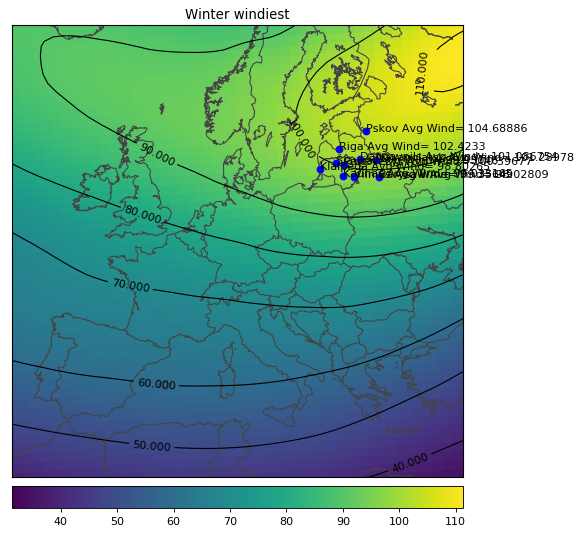

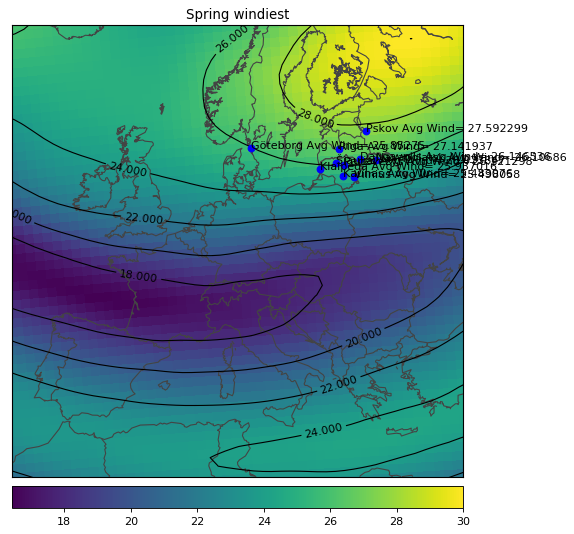

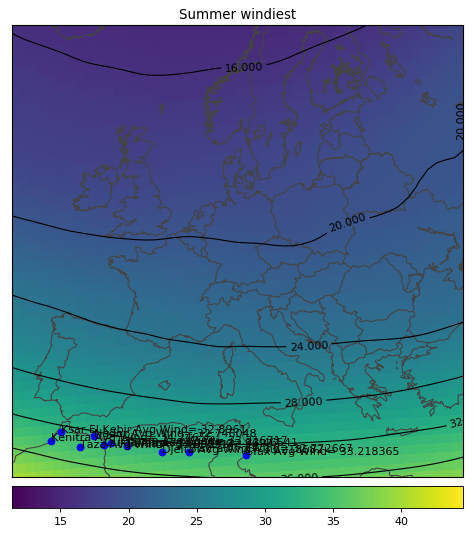

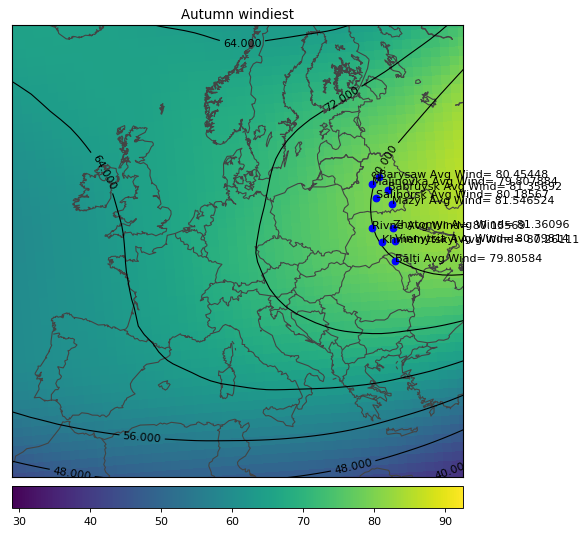

In [65]:
plt.figure(figsize=(8, 8), dpi= 80)
def display_on_map(data, city_list, title=None, lat=lat, lon=lon):
#     im = plt.imread('map-pin.png')

    m = Basemap(width=3800E3, height=3800E3,
                resolution='l', projection='lcc', lat_0 = 50, 
                lon_0 = 10, lat_ts = 40, k_0=1.0)
    m.drawcoastlines(linewidth=1.0, color='#444444')
    m.drawcountries(linewidth=1.0, color='#444444')
    m.drawmapboundary(linewidth=1.0, color='#000000')
    x, y = m(lon, lat)
    try:
        pass
        cs = m.contour(x, y, data, linewidths=1.0, colors='k')
        plt.clabel(cs, inline=1, fontsize=10)
    except:
        pass
    pcl = m.pcolor(x, y, np.squeeze(data))
    cbar = m.colorbar(pcl, location='bottom', pad='2%')

    #     for every city, wind in our list of tuples
    for city, wind in city_list:
        x,y = m(city.longitude,city.latitude)
        plt.text(x, y, city.name+" Avg Wind= "+str(wind))
        m.plot(x, y, 'bo', markersize=6)
    
    if title:
        plt.title(title)
    plt.show()    
display_on_map(magnitude_averages[0,2],q1_cities,title="Winter windiest")
plt.figure(figsize=(8, 8), dpi= 80)
display_on_map(magnitude_averages[1,2],q2_cities,title="Spring windiest")
plt.figure(figsize=(8, 8), dpi= 80)
display_on_map(magnitude_averages[2,2],q3_cities,title="Summer windiest")
plt.figure(figsize=(8, 8), dpi= 80)
display_on_map(magnitude_averages[3,2],q4_cities,title="Autumn windiest")